##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [ ]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$','Upland':'F$_{up}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

In [386]:
def Performance(ax,title,target):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0],
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]])
    plt.sca(ax)
    plt.grid()
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Best = Data[Data['Performance']==1]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    else:
        alpha = .025
        Best = Data[Data['Performance'] == 1]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
#         print(Best)
        print()
        print(Data)
#         print()
    ax.grid()

def Mapper(AllData,target,target_name,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True)
    target.Map()
    AllData[target_name] = target.Data_Map[target.target].values
    AllData[target_name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[target_name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[target_name+'_CI'] = target.Data_Map['CI'].values
    AllData[target_name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)


In [473]:
class ResultMap:
    def __init__(self,target,Test='T',SE_Rule=1):
        self.SE_Rule = SE_Rule
        self.target = target
        self.target_name = target
        if target == 'fco2_Final' or target == 'ER':
            self.target = 'fco2'
            self.target_name = 'ER'
        if target == 'fch4_Final':
            self.target = 'fch4'
            self.target_name = 'fch4'
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)

        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
#             print(Level)
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            elif level == 99:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append('N/A')
                
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
#         Best = level_best.loc[level_best['Performance']==2]
# #         print(Best)
#         try:
#             self.Best = Best.loc[Best['Size']==Best['Size'].max()]
#     #         self.Model_Selection = self.Best.copy()
#             self.Model_Selection = self.Best['Model'].values[0]
#         except:
#             self.Model_Selection = self.Min['Model'].values[0]
#             pass
        self.level_best = level_best
        
        self.Records['T2']=0
        self.Records['Performance'] = 0
        alpha = .025
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
#             Level.loc[Level['MSE'] == Level['MSE'].min(),'Performance']=1
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)
#                 print(-stats.t.ppf(1-alpha,self.params['K'])
                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Performance']+=1
#                 print(Level[['Model','T2']])
            ##SE-Rule
            else:
                Test == 'SE'
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0],'Performance']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        
            Trecords = self.Records.loc[self.Records['Performance']==self.Records['Performance'].max()]
            self.Best = (Trecords.loc[Trecords['Size']==Trecords['Size'].min()])
            self.Model_Selection = self.Best['Model'].values[0]
                
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+'/'+self.target_name+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(self.params['K']))):
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5) 

class Display:
    def __init__(self,targets,target_names):
    
        self.target_options={}
        self.target_names=target_names
        for target,name in zip(targets,target_names):
            self.target_options[name]=target
        self.i = 0
        self.Reset('b')
        
    def Reset(self,b):
        button2 = widgets.Button(description="Reset")
        display(button2)
        button2.on_click(self.Clear) 
        self.Select('b')
            
        
    def Select(self,b):
        self.target = self.target_options[self.target_names[self.i]]
        print('Select Model for: ',self.target_names[self.i])
        self.size = widgets.IntSlider(
            value=self.target.Best['Size'].values[0],
            min=1,
            max=self.target.level_best['Size'].max(),
            step=1,
            description='Model Size:',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        display(self.size)
        button = widgets.Button(description="Query Models")
        display(button)
        button.on_click(self.Select_Models) 
    
    def Clear(self,b):
        clear_output()
        self.i = 0
        self.Reset('b')
        
    def Select_Models(self,b):
        self.Model_Selection = widgets.Select(
        options=self.target.Records.loc[self.target.Records['Size']==self.size.value,'Model'].values,
        value=self.target.level_best.loc[self.target.level_best['Size']==self.size.value,'Model'].values[0],
        # rows=10,
        layout=Layout(width='100%'),
        description='Model:',
        disabled=False
        )
        display(self.Model_Selection)
            
        button = widgets.Button(description="Analyze This Model")
        display(button)
        button.on_click(self.Choose)
        
    def Choose(self,b):
        print(self.target.Model_Selection)
        self.target.Model_Selection = self.Model_Selection.value
        self.i +=1
        if self.i < len(self.target_names):
            self.Select('b')      

In [474]:

fco2 = ResultMap('fco2',Test='SE')
fch4 = ResultMap('fch4',Test='SE')
ER = ResultMap('ER')
ER.Model_Selection=ER.Records['Model'].values[0]


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


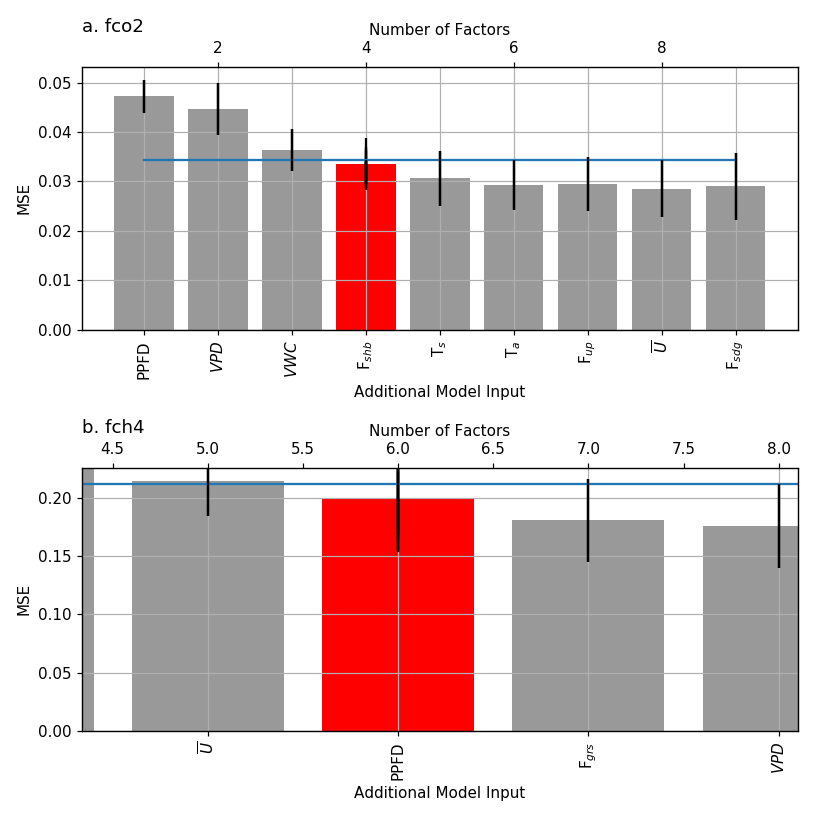

                          Model       MSE  Size  Number        SE  \
27  wind_speed+PPFD_Avg+VPD+VWC  0.032798     4       0  0.004125   
28   PPFD_Avg+AirTC_Avg+VPD+VWC  0.032275     4       1  0.003904   
31       PPFD_Avg+VPD+VWC+Shrub  0.031927     4       4  0.002488   
32       PPFD_Avg+VPD+VWC+Grass  0.033587     4       5  0.005156   
33      PPFD_Avg+VPD+VWC+Upland  0.033330     4       6  0.003238   

    Performance         T  T2 Model_Key  
27            1  0.989995   0       4_0  
28            1  0.411518   0       4_1  
31            1  0.000000   0       4_4  
32            1  1.588673   0       4_5  
33            1  1.881661   0       4_6  
                                         Model       MSE  Size  Number  \
40   wind_speed+PPFD_Avg+Temp+VWC+Sedge+Upland  0.193799     6       0   
41  wind_speed+AirTC_Avg+Temp+VWC+Sedge+Upland  0.199381     6       1   
42        wind_speed+VPD+Temp+VWC+Sedge+Upland  0.195636     6       2   
43      wind_speed+Temp+VWC+Sedge+Shr

<IPython.core.display.Javascript object>


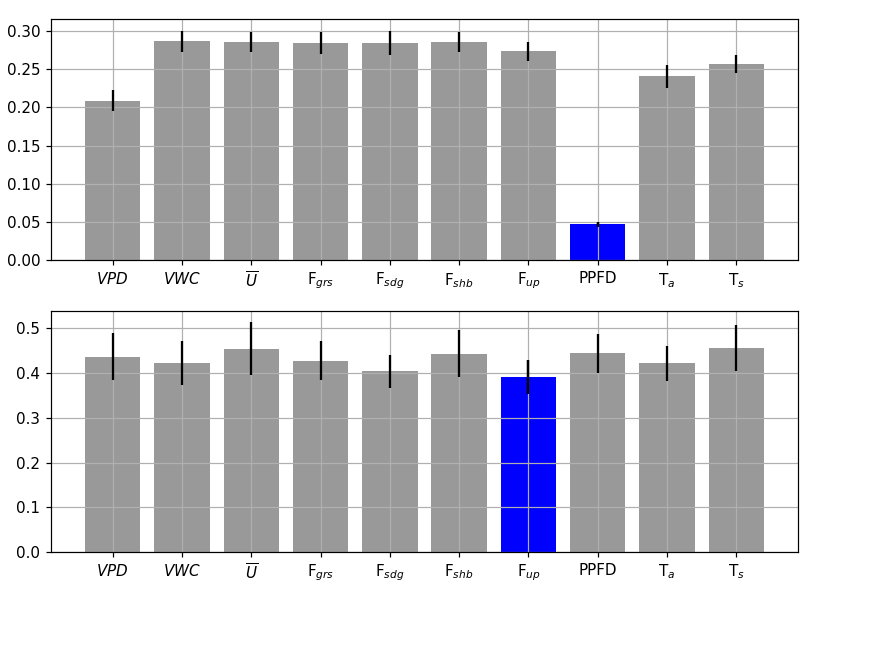

Empty DataFrame
Columns: [index, Model, MSE, Size, Number, SE, Performance, T, T2, Model_Key, Name]
Index: []
Empty DataFrame
Columns: [index, Model, MSE, Size, Number, SE, Performance, T, T2, Model_Key, Name]
Index: []


In [475]:

    
MP=False
Scope = 'Test'
cwd = os.getcwd()
# cwd = 'C:\\Users\\wesle\\Backup'
Site='Illisarvik'
Fill = False


fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
Performance(ax[0],'a. fco2',fco2)
Performance(ax[1],'b. fch4',fch4)
plt.tight_layout()
# plt.savefig('Test.png')


plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7.png',dpi=300)


fig,ax=plt.subplots(2,1,figsize=(7.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=1)
LevelPerformance(ax[1],'b. fch4',fch4,level=1)
plt.tight_layout()

In [521]:
print(fco2.Model_Selection)

PPFD_Avg+VPD+VWC+Shrub


In [477]:

Disp = Display([fco2,fch4],['fco2','fch4'])

A Jupyter Widget

Select Model for:  fco2


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

PPFD_Avg+VPD+VWC+Shrub
Select Model for:  fch4


A Jupyter Widget

A Jupyter Widget

In [262]:


import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

T30 = fco2.RST.Master.copy()
T30['TA'] = T30['AirTC_Avg'].shift(-2)

T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
Vars = ['TA','AirTC_Avg','NR_Wm2_Max','wind_speed','Rain_mm_Tot','VPD','DOY','DOY2','Temp','VWC']
test = T30.loc[T30['DOY']<200,Vars].dropna()
Key = Vars[0:5]
forest=LinearRegression().fit(test[Key],test['Temp'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','Temp','AirTC_Avg']].dropna()
# print(metrics.r2_score(test['Temp'],test['TempFIll']))
T30['Temp']=T30['Temp'].fillna(T30['TempFIll'])
test = T30[Vars].dropna()
Key=['DOY','DOY2','Temp','Rain_mm_Tot']
forest = LinearRegression().fit(test[Key],test['VWC'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','VWC',]].dropna()
# print(metrics.r2_score(test['VWC'],test['TempFIll']))
T30['VWC']=T30['VWC'].fillna(T30['TempFIll'])




In [305]:

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg']=T30['PPFD_Avg'].min()

T30_Fixed = T30.copy()
T30_AntiFixed = T30.copy()
FPRatios = {'Sedge':.122,
            'Sparse':.085,
            'Shrub':.602,
            'Grass':.159,
            'Upland':0.0,
            'Out_of_Basin':0.0
}

# FPRatios = {'Sedge':1,
#             'Sparse':0.0,
#             'Shrub':0.0,
#             'Grass':0.0,
#             'Upland':0.0,
#             'Out_of_Basin':0.0
# }


for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
    T30_Fixed[var] = FPRatios[var]
    
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()

# T30 = Mapper(T30,ER,'ER_fixed_est',T30_Dark_Fixed)#fco2
# print('ER_fixed_est')
# T30 = Mapper(T30,ER,'ER_est',T30_Dark)#fco2
# print('ER_est')
# T30 = Mapper(T30,fco2,'NEE_fixed_est',T30_Fixed)#,T30_Fixed)
# print('NEE_fixed_est')
# T30 = Mapper(T30,fco2,'NEE_est')#,T30_Fixed)
# print('NEE_est')
# T30 = Mapper(T30,fch4,'NME_Sedge_est',T30_Fixed)#,T30_Fixed)
# print('NME_Sedge_est')
# T30 = Mapper(T30,fch4,'NME_est')#,T30_Fixed)
# print('NME_est')

NME_Sedge_est


<IPython.core.display.Javascript object>


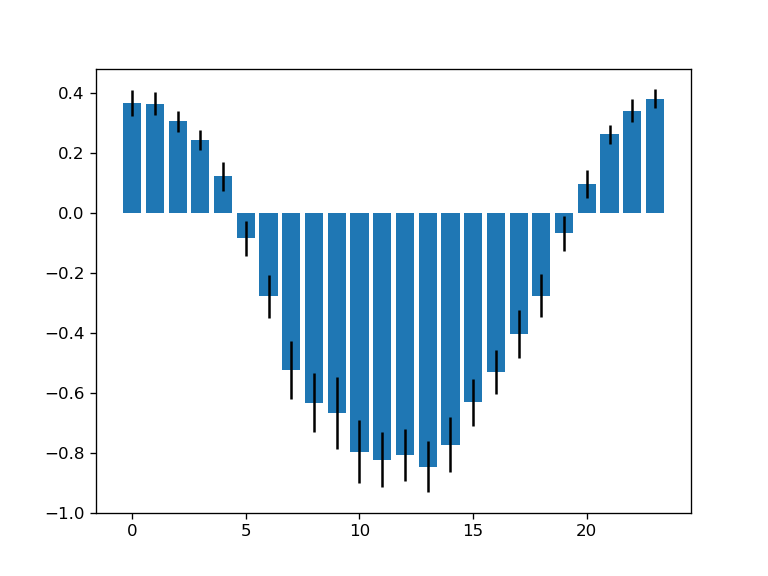

0.3796927522796549 0.03186031091596446
-0.8473384190871504 0.08504402732127594


In [622]:
Days = T30.groupby(T30.index.hour).mean()
DaysS = T30.groupby(T30.index.hour).std()
DaysC = T30.groupby(T30.index.hour).count()
Days['NEES']=DaysS['NEE']
Days['NEEC']=DaysC['NEE']


plt.figure()
plt.bar(Days.index,Days['NEE'],yerr=DaysS['NEE']/DaysC['NEE']**.5*stats.t.ppf(1-0.025,DaysC['NEE']))
# print(Days['NEE'].max(),Days['NEE'].min())
Max = (Days.loc[Days['NEE']==Days['NEE'].max(),['NEE','NEES','NEEC']])
Min = (Days.loc[Days['NEE']==Days['NEE'].min(),['NEE','NEES','NEEC']])
# print(T30['NEE'].max(),T30['NEE'].min())
print(Max['NEE'].values[0],(Max['NEES']/Max['NEEC']**.5*stats.t.ppf(1-0.025,Max['NEEC'])).values[0])
print(Min['NEE'].values[0],(Min['NEES']/Min['NEEC']**.5*stats.t.ppf(1-0.025,Min['NEEC'])).values[0])
# plt.title('Respiration Dominant Fluxes')
# Dark = T30.loc[T30['PPFD_Avg']<=10]
# DarkC = Dark.resample('D').count()
# Resp = T30.loc[T30['fco2']>=0]
# RespC = Resp.resample('D').count()
# plt.bar(RespC.index,RespC['fco2'])
# plt.bar(DarkC.index,DarkC['fco2'])
# # print(Dark['fco2'].mean()*24)
# print(RespC['fco2'].mean()*24)

In [266]:
def PooledVar_interval(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Sp = (n-1)*T30['Pooled_Var'].sum()/((n-1)*T30.shape[0])
    return(Sp)

def Pooledstd_interval_pop(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Term1 = T30['Pooled_Var'].mean()
    df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
    Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
    Sp = Term1+Term2
    return(Sp)


def Pooledstd_interval(T30,Vars,target,mean): 
    ##https://en.wikipedia.org/wiki/Pooled_variance#Sample-based_statistics
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    P1 = 1/((n-1)*T30['Pooled_Var'].shape[0])
    P2_T1 = ((n-1)*T30['Pooled_Var']+n*T30[mean]**2).sum()
    P2_T2 = (n*T30['Pooled_Var'].shape[0])*T30[mean].mean()**2
    Sp = (P1*(P2_T1-P2_T2))**.5
#     print(Sp,P1,P2_T1-P2_T2,P2_T1,P2_T2)
#     Term1 = T30['Pooled_Var'].mean()
#     df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
#     Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
#     Sp = Term1+Term2
    return(Sp)

T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
T30['NME'] = T30['fch4'].fillna(T30['NME_est'])

T30['GPP'] = T30['NEE']-T30['ER_est']
T30['GPP_est'] = T30['NEE_est']-T30['ER_est']
T30['GPP_fixed_est'] = T30['NEE_fixed_est']-T30['ER_fixed_est']

#

In [456]:
PooledVar_interval = Pooledstd_interval
mult = 24
Estimates = []
CIs = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
for Var in ['NEE','NEE_fixed_est','ER_est','ER_fixed_est','GPP_est','GPP_fixed_est','NME','NME_fixed_est']:
# Var = 'NEE'
    if Var == 'NEE' or Var == 'NME':
        CIPI = 'CI'
        Int=T30[Var].std()/(T30[Var].count()**.5) *stats.t.ppf(1-.025,T30[Var].count())*mult
        Type.append('EC Obs.')
        Fluxes.append(Var)
    elif Var[:3]=='GPP':
        Int=0
        Fluxes.append(Var.split('_')[0])
        Type.append('NN est.')
        
    else:
        
        Fluxes.append(Var.split('_')[0])
        CIPI = 'PI'
        Type.append('NN est.')
        pooled_std = PooledVar_interval(T30,
            [Var+'_Var_reg',Var+'_Var_er'],fco2,'NEE_est')
        Int=pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30[Var].count())*mult
#     print(Var)
    U = T30[Var].mean()*mult
#     print('Mean: ',U)
    
#     print(CIPI+': ',Int)
#     print('Var: ',T30[Var].std()**2)

    Estimates.append(U)
    CIs.append(Int)
    if len(Var.split('_'))!=3:
        Scale.append('Footprint')
    else:
        Scale.append('Basin')
    Samples.append(T30[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'Interval Type':IntType,'N':Samples,
       'Type':Type}
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
print(All)


   Flux      Scale  Estimates  95% CI/PI Interval Type            N     Type
0    ER  Footprint  10.347299   0.975334            PI  1296.000000  NN est.
1    ER      Basin  10.071477   0.976175            PI  1296.000000  NN est.
2    ER  Footprint  14.826690   3.618140            CI    74.920521  Chamber
3    ER      Basin  13.601409   3.846433            CI    56.365620  Chamber
4   GPP  Footprint -15.965448   0.000000            PI  1296.000000  NN est.
5   GPP      Basin -14.850457   0.000000            PI  1296.000000  NN est.
6   NEE  Footprint  -5.669766   0.680023            CI  1296.000000  EC Obs.
7   NEE      Basin  -4.778987   1.001580            PI  1296.000000  NN est.
8   NME  Footprint  12.195310   0.826999            CI  1296.000000  EC Obs.
9   NME      Basin  12.330454   1.336658            PI  1296.000000  NN est.
10  NME  Footprint  17.086510  11.525820            CI    74.920521  Chamber
11  NME      Basin  19.406718  13.525331            CI    56.365620  Chamber

<IPython.core.display.Javascript object>


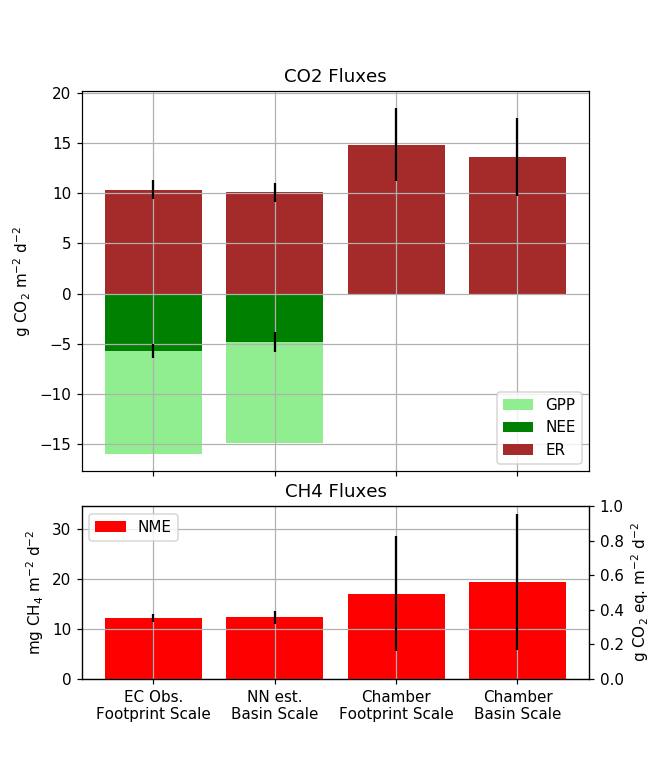

In [498]:
fig,ax = plt.subplots(2,1,figsize = (6,7),sharex=True)


ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0))

Labels =['EC Obs.\nFootprint Scale','NN est.\nBasin Scale','Chamber\nFootprint Scale','Chamber\nBasin Scale']
# ax1.bar([2,3],[0,0],
#         color='None')
ax1.bar([0,1],All.loc[All['Flux']=='GPP','Estimates'],color='lightgreen',label = 'GPP')
ax1.bar([0,1],All.loc[All['Flux']=='NEE','Estimates'],
        yerr = All.loc[All['Flux']=='NEE','95% CI/PI'],color='green',label='NEE')
# ax1.bar([2,3],[0,0],
#         color='None')

ax1.bar([0,1,2,3],All.loc[All['Flux']=='ER','Estimates'],
        yerr = All.loc[All['Flux']=='ER','95% CI/PI'],color='brown',label='ER')

Conv = 28*1e-3
ax2=ax3.twinx()
ax3.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates'],
        yerr = All.loc[All['Flux']=='NME','95% CI/PI'],color='red',label='NME')
# ax2.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates']*Conv,color='None',label='')
ax3.set_xticks([0,1,2,3])
ax1.set_xticks([0,1,2,3])
ax3.set_xticklabels(Labels)
ax1.set_xticklabels([])
ax1.legend(loc=4)
ax1.grid()
ax1.set_title('CO2 Fluxes')
ax1.set_ylabel('g CO$_2$ m$^{-2}$ d$^{-2}$')
ax3.legend(loc=2)
ax3.grid()
ax3.set_title('CH4 Fluxes')
ax3.set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-2}$')
ax2.set_ylabel('g CO$_2$ eq. m$^{-2}$ d$^{-2}$')
# ax3.bar([2,3],[0,0],
#         color='None')
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/fig5.png')  

In [312]:
# fco2_final = fco2
# fch4_final = fch4

H1 = T30.resample('D').mean()
H1['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
H1s = T30.resample('D').std()
for v in ['ER_est_','ER_fixed_est_','NEE_est_','NEE_fixed_est_','NME_est_','NME_fixed_est_','NME_Sedge_est_']:
    H1[v+'Pooled_CI'] = 0
    for day in H1.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        pooled_std = PooledVar_interval(Samp,
                [v+'Var_reg',v+'Var_er'],fco2_final,v[:-1])**.5
#         print()
#         print(pooled_std)
#         print(Samp[[v+'Var_reg',v+'Var_er']].sum(axis=1).mean()**.5)
        H1.loc[H1.index==day,v+'Pooled_CI']=pooled_std/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
        H1.loc[H1.index==day,v+'Pooled_PI']=pooled_std*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

# plt.figure()
# plt.plot(H1['ER_est_Pooled_CI'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [433]:
mult = 24
print('Cbal', T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28)
print('Cbal', T30['NEE_fixed_est'].mean()*mult+T30['NME_fixed_est'].mean()*mult*1e-3*28)
# print(H1['NEE'].min()*24,H1['NEE'].max()*24)


Cbal -5.328297170106149
Cbal -4.433734580039978


<IPython.core.display.Javascript object>


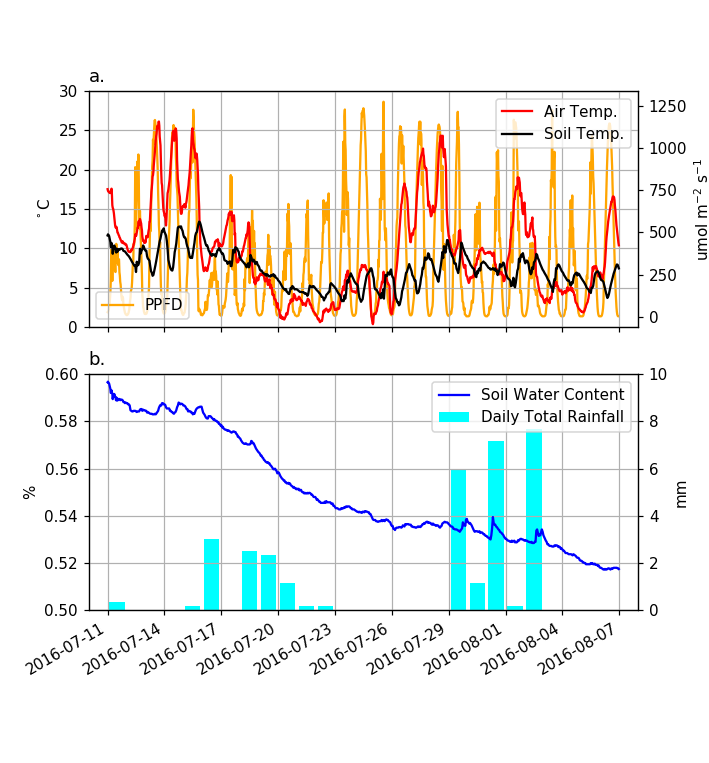

<IPython.core.display.Javascript object>


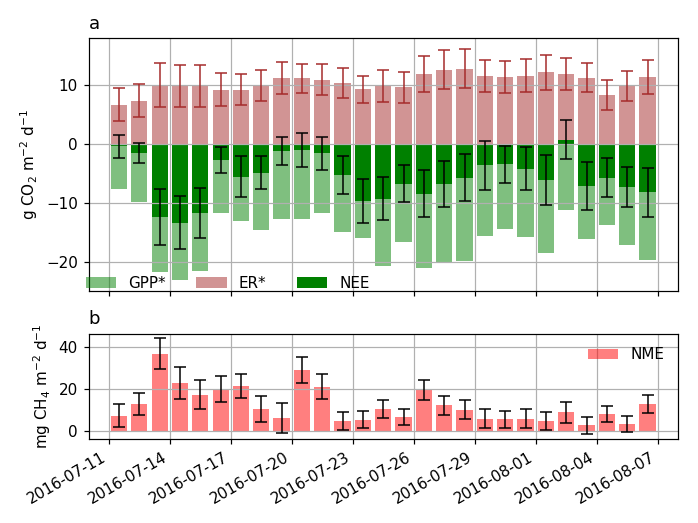

In [356]:
fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'Air Temp.')
ax[0].plot(T30['Temp'],color='black',label = 'Soil Temp.')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.plot(T30['PPFD_Avg'],color='orange',label='PPFD')

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('umol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend()
yax2.legend(loc=3)
ax[0].set_title('a.',loc='left')

yax2 = ax[1].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['Rain_mm_Tot'],color='cyan',label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,color='cyan',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].legend()
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_title('b.',loc='left')
fig.autofmt_xdate()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)


fig = plt.figure()
ax0 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
ax=[ax0,ax1]

mult = 24
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['GPP_est']*mult,
          color='green',
          label='GPP*',
#           yerr = H1['ER_est_Pooled_CI'],#*mult,
#           error_kw=dict(ecolor='green', lw=1, capsize=4, capthick=1),
          alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['ER_est']*mult,
          yerr = H1['ER_est_Pooled_PI']*mult,
          error_kw=dict(ecolor='brown', lw=1, capsize=4, capthick=1),
          color='brown',label='ER*',alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['NEE']*mult,
#           yerr = H1['NEE_est_Pooled_CI']*mult,#/(48**.5)*stats.t.ppf(1-.025,48),#*mult,
          yerr = H1s['NEE']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='green',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[0].grid()
ax[0].set_title('a',loc='left')
ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ d$^{-1}$')
ax[0].legend(bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=3,loc=4)

ax[0].set_xticklabels([])
# ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME_Sedge_est']*mult,
#           yerr = H1['NME_Sedge_est_Pooled_CI']*mult,
# #           yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
#           color='green',
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           alpha=.5,
#           label ='NME_Sedge_est')
ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME']*mult,
          yerr = H1['NME_est_Pooled_CI']*mult,
#           yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='red',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          alpha=.5,
          label ='NME')
ax[1].grid()
ax[1].set_title('b',loc='left')
ax[1].set_ylabel('mg CH${_4} $ m$^{-2}$ d$^{-1}$')

ax[0].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].legend(facecolor='None',
         edgecolor='None',)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)


<IPython.core.display.Javascript object>


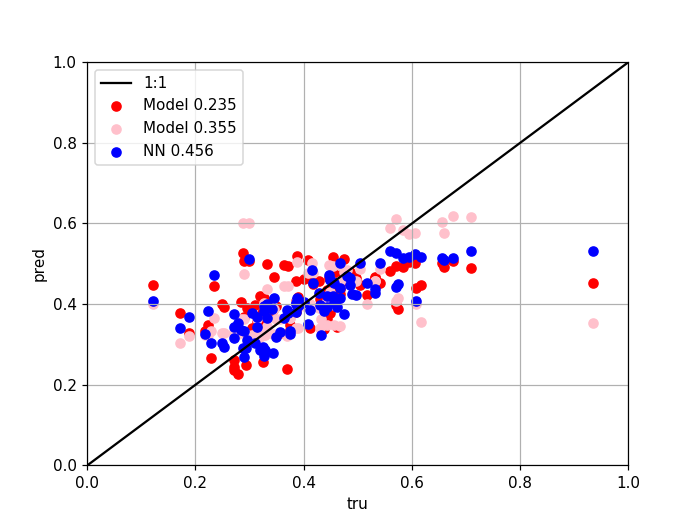

Mean ER:
ER         9.973933
ER_est    10.267147
ER2        9.156432
ER3       11.576413
dtype: float64

R2 Score:
ER_est:  0.4557464348084522 ER2:  0.23450566867643263 ER3:  0.3554159517869474

MSE:
ER_est:  2.616316894442269 ER2:  3.1028493758980957 ER3:  2.8472754342314346
GPP_est   -17.439660
GPP2      -16.147904
GPP3      -18.388965
dtype: float64
NEE       -7.245154
NEE_est   -7.172514
NEE2      -6.991472
NEE3      -6.812552
dtype: float64
96 921 0.10423452768729642


In [280]:

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','AirTC_Avg']].dropna()


# print(T30.loc[T30['PPFD_Avg']<10,['Temp','fco2']].drop)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))

#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),3)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),3))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='NN '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_est']),3)))
# plt.colorbar()
plt.plot([0,1],[0,1],label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = -1*P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = -1*P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['GPP2']+T30['ER2']
T30['NEE3'] = T30['GPP3']+T30['ER3']

# popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['fco2']-,p0=(.003,12))
# Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
# Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)



# T30['GPP'] = T30['NEE']-T30['ER_est']
# T30['GPP2'] = T30['NEE_est']-T30['ER2']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult)
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5*24,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5*24,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5*24)
print(Temp[['GPP_est','GPP2','GPP3']].mean()*mult)
print(Temp[['NEE','NEE_est','NEE2','NEE3']].mean()*mult)
print(Temp['ER'].count(),T30['fco2'].count(),T30['ER'].count()/T30['fco2'].count())

<IPython.core.display.Javascript object>


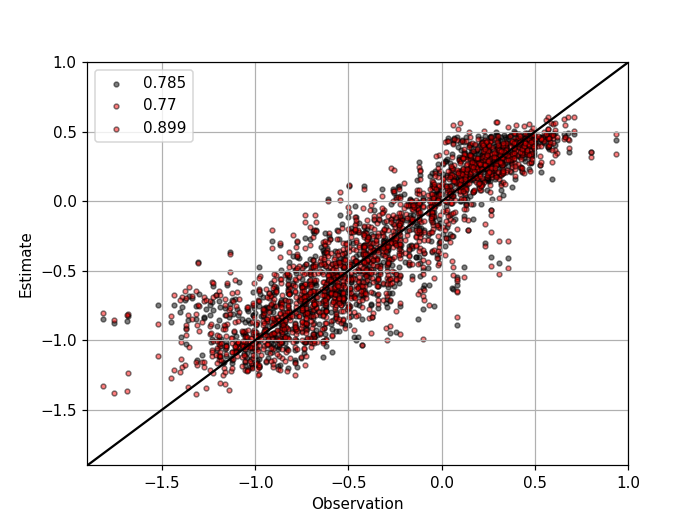

(-1.9, 1)

In [523]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
plt.plot([-1.9,1],[-1.9,1],color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
plt.ylim(-1.9,1)
plt.xlim(-1.9,1)



In [515]:
def Plot(ax,Label,Data,regressor,color,target,Interval='CI',linestyle='-',mult=1):
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            color = color)   
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
#                     facecolor='None',
                    alpha = .25,
#                     edgecolor = color, 
                    color = color, 
                    linestyle=':',
                    linewidth=2,
#                     label = '90% '+Interval
                   )


In [597]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def QQ(target,Range,N,Mask={},map_range=None):
    
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:

        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
#         print(kmeans)
#         print(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
        
    def Make(Data,columns,map_range,values,C=20,Mask=None):
        ranges = [np.linspace(map_range[0],map_range[1],C)]
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
#         print(Mask)
#         for key, item in Mask.items():
#             print(item)
#         for key,item in Mask.items():
#             print(key,item[0])
        Data = Make(target.RST.Data,columns,
                    
                    map_range=map_range,#target.RST.Data[columns[0]].min(),1],#target.RST.Data[columns[0]].max()],
                    values=values,Mask={key:item[i] for key, item in Mask.items()})
        target.RST.Data=Data
        target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
        target.Map()
        tarList.append(target.Data_Map)  
    return(tarList,Q,columns[l:-1])

# print([T30['VPD'].mean() for i in range(4)])
N = 4
tarList,means,columns=QQ(target,differential,N=N,
                         Mask={'VPD':[T30['VPD'].mean() for i in range(4)],#
                               'VWC':np.asanyarray([.6,.5,.6,.5]),
                               'Shrub':np.asanyarray([0,0,1,1]),
                               },
#                          map_range=[0,1]
                        )

In [607]:
# print(len(tarList))
columns=['VPD','VWC','Shrub']

4


In [588]:
i=0
colors = ['red']#,'green','blue']#,'indigo','violet']
differential='PPFD_Avg'
target = fco2
fco2.Model_Selection='PPFD_Avg'
line = '-'
N=len(colors)
tarList,means,columns=QQ(target,differential,N=N,
#                          Mask={'Upland':[0 for i in range(N)],
#                                'VWC':np.asanyarray([.75,.5,.75,.5]),
#                                'Temp':np.asanyarray([12,12,5,5]),
#                                'wind_speed':[T30['wind_speed'].mean() for i in range(N)],#
#                                'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],#
#                                },
#                          map_range=[0,1]
                        )

fig,ax=plt.subplots(2,1,figsize=(7,10))
for Data,color in zip(tarList,colors):
#     print(i)
#     label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))])
    label = 'Model Response'
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'PI',linestyle=line,mult=24)
    ax[0].scatter(T30['PPFD_Avg'],T30['fco2']*mult,c='k',s=10,label = 'Observations')
    ax[0].set_xlabel(differential)
    if target == fch4:
        ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-2}$')
        tar = 'fch4'
    else:
        ax[0].set_ylabel('g CO$_2$ m$^{-2}$ d$^{-2}$')
        tar = 'fco2'
    
    
    
    label = 'Quantum Yield'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
#            label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
           label = label,
           color = color)
    ax[1].set_ylabel('d'+tar+'/d'+differential)
    i += 1
ax[0].legend(fontsize=10,loc=1)
ax[0].grid()
ax[1].legend()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7_A.png',dpi=300)
# ax[1].grid()

# plt.figure()
# plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['PPFD_Avg'])#,color='color',label='Var_er')
print(Data['fco2'].max()*mult)

['PPFD_Avg']
{}
[]
[[0]]


TypeError: 'NoneType' object is not iterable

[[326.7237617   0.6         0.       ]
 [326.7237617   0.5         0.       ]
 [326.7237617   0.6         1.       ]
 [326.7237617   0.5         1.       ]] ['VPD', 'VWC', 'Shrub']
          VPD  VWC  Shrub
0  326.723762  0.6    0.0
1  326.723762  0.5    0.0
2  326.723762  0.6    1.0
3  326.723762  0.5    1.0


<IPython.core.display.Javascript object>


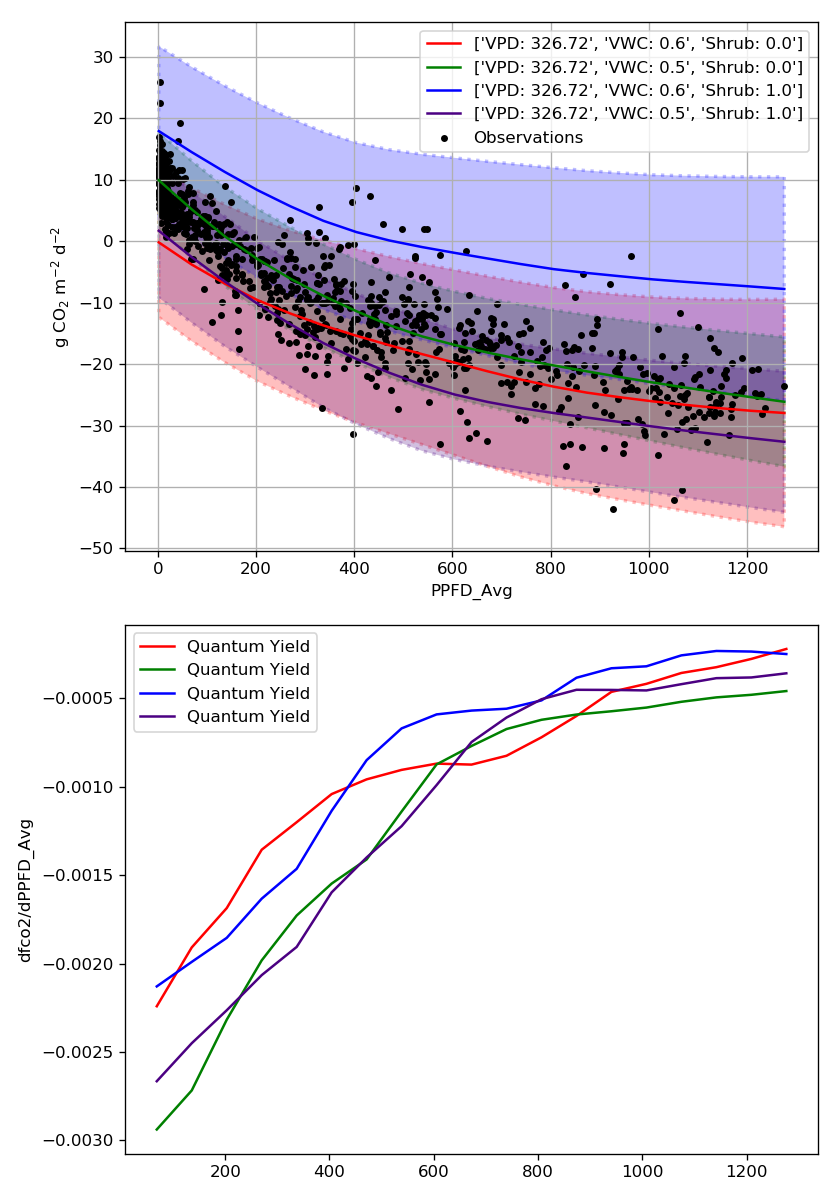

0
1
2
3
1.6871627569198608


In [608]:
i=0

colors = ['red','green','blue','indigo']#,'violet']
differential='PPFD_Avg'
target = fco2
fco2.Model_Selection='PPFD_Avg+VPD+VWC+Shrub'
line = '-'
N=len(colors)
# tarList,means,columns=QQ(target,differential,N=N,
# #                          Mask={'Upland':[0 for i in range(N)],
# #                                'VWC':np.asanyarray([.75,.5,.75,.5]),
# #                                'Temp':np.asanyarray([12,12,5,5]),
# #                                'wind_speed':[T30['wind_speed'].mean() for i in range(N)],#
# #                                'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],#
# #                                },
# #                          map_range=[0,1]
#                         )
print(means,columns)
Kdata = pd.DataFrame(data=means,columns=columns)
print(Kdata)

fig,ax=plt.subplots(2,1,figsize=(7,10))
for Data,color in zip(tarList,colors):
    print(i)
    label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))])
#     label = 'Model Response'
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'PI',linestyle=line,mult=24)
    ax[0].set_xlabel(differential)
    if target == fch4:
        ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-2}$')
        tar = 'fch4'
    else:
        ax[0].set_ylabel('g CO$_2$ m$^{-2}$ d$^{-2}$')
        tar = 'fco2'
    
    
    
    label = 'Quantum Yield'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
#            label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
           label = label,
           color = color)
    ax[1].set_ylabel('d'+tar+'/d'+differential)
    i += 1
    
ax[0].scatter(T30['PPFD_Avg'],T30['fco2']*mult,c='k',s=10,label = 'Observations')
ax[0].legend(fontsize=10,loc=1)
ax[0].grid()
ax[1].legend()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7_B.png',dpi=300)
# ax[1].grid()

# plt.figure()
# plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['PPFD_Avg'])#,color='color',label='Var_er')
print(Data['fco2'].max()*mult)

In [ ]:
i=0

colors = ['red']#,'green','blue']#,'indigo','violet']
differential='Upland'
target = fch4
fch4.Model_Selection='Upland'
line = '-'
N=len(colors)
# tarList,means,columns=QQ(target,differential,N=N,
# #                          Mask={'Upland':[0 for i in range(N)],
# #                                'VWC':np.asanyarray([.75,.5,.75,.5]),
# #                                'Temp':np.asanyarray([12,12,5,5]),
# #                                'wind_speed':[T30['wind_speed'].mean() for i in range(N)],#
# #                                'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],#
# #                                },
# #                          map_range=[0,1]
#                         )

# Kdata = pd.DataFrame(data=means,columns=columns)
# print(Kdata)

fig,ax=plt.subplots(2,1,figsize=(7,10))
for Data,color in zip(tarList,colors):
#     print(i)
#     label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))])
    label = 'Model Response'
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'PI',linestyle=line,mult=24)
    ax[0].scatter(T30['Upland'],T30['fch4']*mult,c='k',s=10,label = 'Observations')
    ax[0].set_xlabel(differential)
    if target == fch4:
        ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-2}$')
        tar = 'fch4'
    else:
        ax[0].set_ylabel('g CO$_2$ m$^{-2}$ d$^{-2}$')
        tar = 'fco2'
    
    
    
    label = '1st Derivative'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
#            label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
           label = label,
           color = color)
    ax[1].set_ylabel('d'+tar+'/d'+differential)
    i += 1
ax[0].legend(fontsize=10,loc=1)
ax[0].grid()
ax[1].legend()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7_C.png',dpi=300)
# ax[1].grid()

# plt.figure()
# plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['PPFD_Avg'])#,color='color',label='Var_er')
# print(Data['fco2'].max()*mult)

   wind_speed    PPFD_Avg      Temp       VWC     Sedge
0    3.396213  426.931111  7.644498  0.549920  0.456369
1    3.581709  383.131411  5.797912  0.533820  0.024880
2    4.726393  312.310723  9.314643  0.578786  0.011643
[[3.39621303e+00 4.26931111e+02 7.64449812e+00 5.49920226e-01
  4.56368627e-01]
 [3.58170856e+00 3.83131411e+02 5.79791205e+00 5.33819551e-01
  2.48803524e-02]
 [4.72639348e+00 3.12310723e+02 9.31464267e+00 5.78785995e-01
  1.16426243e-02]]


<IPython.core.display.Javascript object>


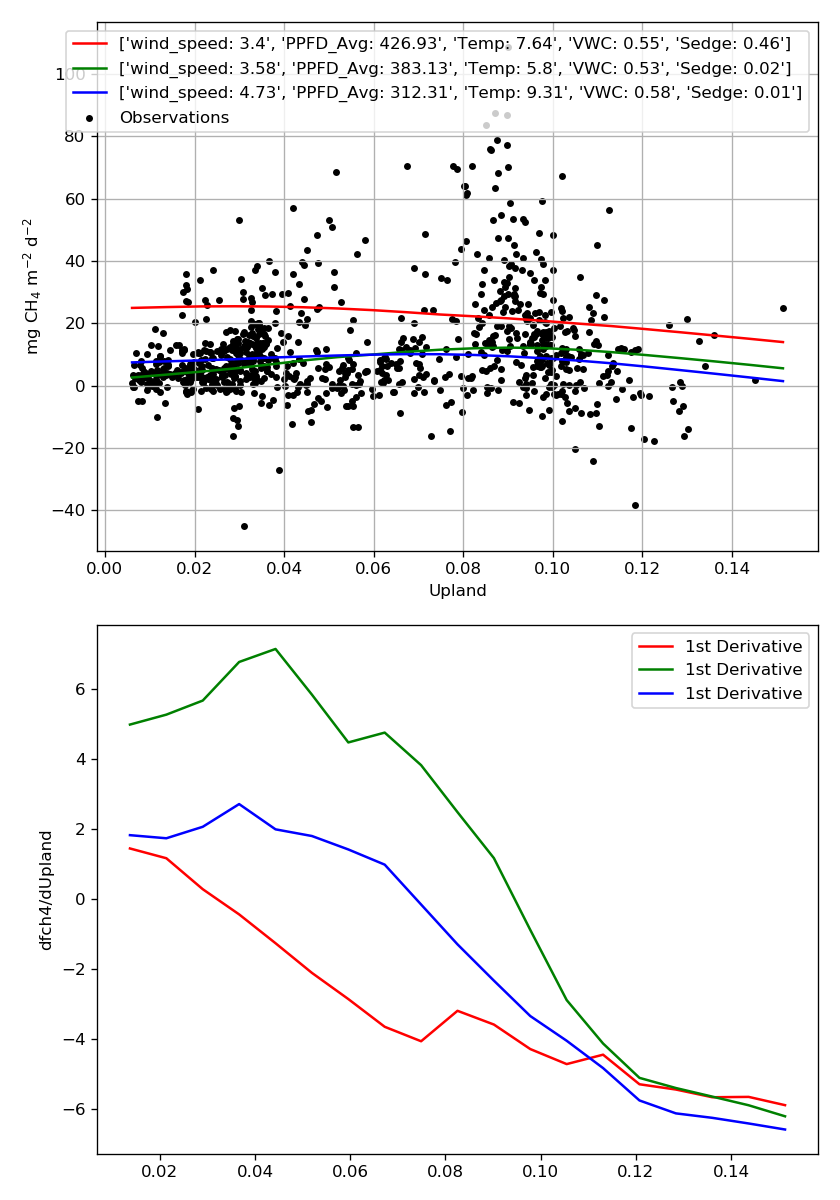

In [546]:
i=0

colors = ['red','green','blue']#,'indigo','violet']
differential='Upland'
target = fch4
fch4.Model_Selection='wind_speed+PPFD_Avg+Temp+VWC+Sedge+Upland'
line = '-'
N=len(colors)
# tarList,means,columns=QQ(target,differential,N=N,
# #                          Mask={'Upland':[0 for i in range(N)],
# #                                'VWC':np.asanyarray([.75,.5,.75,.5]),
# #                                'Temp':np.asanyarray([12,12,5,5]),
# #                                'wind_speed':[T30['wind_speed'].mean() for i in range(N)],#
# #                                'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],#
# #                                },
# #                          map_range=[0,1]
#                         )

Kdata = pd.DataFrame(data=means,columns=columns)

fig,ax=plt.subplots(2,1,figsize=(7,10))
for Data,color in zip(tarList,colors):
#     print(i)
    label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))])
#     label = 'Model Response'
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = None,linestyle=line,mult=24)
    ax[0].set_xlabel(differential)
    if target == fch4:
        ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-2}$')
        tar = 'fch4'
    else:
        ax[0].set_ylabel('g CO$_2$ m$^{-2}$ d$^{-2}$')
        tar = 'fco2'
    
    
    
    label = '1st Derivative'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
#            label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
           label = label,
           color = color)
    ax[1].set_ylabel('d'+tar+'/d'+differential)
    i += 1
ax[0].scatter(T30['Upland'],T30['fch4']*mult,c='k',s=10,label = 'Observations')
ax[0].legend(fontsize=10,loc=1)
ax[0].grid()
ax[1].legend()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7_D.png',dpi=300)
# ax[1].grid()

# plt.figure()
# plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['PPFD_Avg'])#,color='color',label='Var_er')
# print(Data['fco2'].max()*mult)

1.6466081533560937


<IPython.core.display.Javascript object>


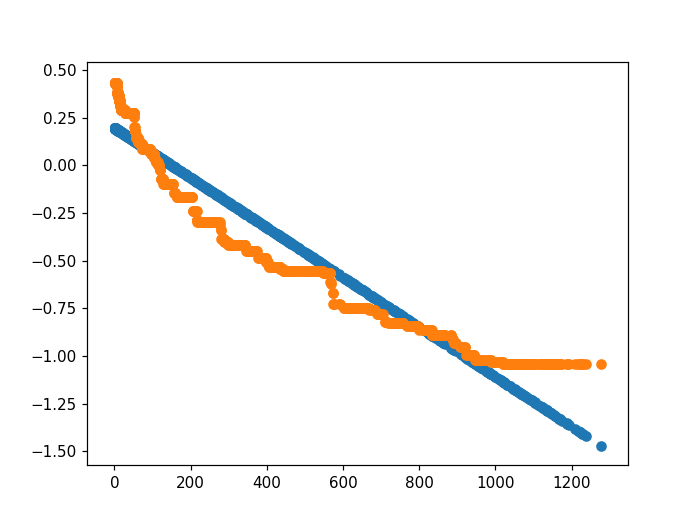

1.055667435503933


In [520]:
fch4.Project(Projector = None,Model = None)
fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']])*mult)
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)

forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']])*mult)